# Tear-film diffusion-SBI data pipeline smoke test

This notebook tests:
- `h5_dataset.py` (load + downsample)
- `data_split.py` (train/test/val split)
- `theta_transform.py` (standardize theta using **train only**)
- `noise_model.py` (multiplicative noise: $x=I(1+0.01z)$)


In [1]:
import sys
import os

# Path to src/data directory
project_root = r"C:\Users\arnab\OneDrive\Desktop\Study material\Research\tearfilm_diffusion_sbi"
data_path = os.path.join(project_root, "src", "data")

if data_path not in sys.path:
    sys.path.append(data_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from h5_dataset import load_dataset
from data_split import split_dataset
from theta_transform import theta_transform
from noise_model import add_multiplicative_noise

np.random.seed(0)

In [3]:
I_clean, theta = load_dataset(downsample_to=101)

print("Loaded:")
print("  I_clean:", I_clean.shape, I_clean.dtype)
print("  theta  :", theta.shape, theta.dtype)

assert I_clean.ndim == 2 and I_clean.shape[1] == 101, "Expected I_clean shape [N, 101]."
assert theta.ndim == 2 and theta.shape[1] == 6, "Expected theta shape [N, 6]."
assert I_clean.shape[0] == theta.shape[0], "I_clean and theta must have same N."

Loaded:
  I_clean: (64522, 101) float32
  theta  : (64522, 6) float32


In [4]:
splits = split_dataset(I_clean, theta, train_frac=0.7, test_frac=0.2, val_frac=0.1, shuffle=True, seed=42)

I_train, theta_train = splits[0]
I_test, theta_test = splits[1]
I_val, theta_val = splits[2]

print("Splits:")
print("  Train:", I_train.shape, theta_train.shape)
print("  Test :", I_test.shape, theta_test.shape)
print("  Val  :", I_val.shape, theta_val.shape)

assert I_train.shape[1] == 101 and theta_train.shape[1] == 6
assert I_test.shape[1] == 101 and theta_test.shape[1] == 6
assert I_val.shape[1] == 101 and theta_val.shape[1] == 6

Splits:
  Train: (45165, 101) (45165, 6)
  Test : (12904, 101) (12904, 6)
  Val  : (6453, 101) (6453, 6)


In [5]:
I_train_clean, theta_tilde, mu, s = theta_transform(splits[0])

print("Theta transform (train only):")
print("  I_train_clean:", I_train_clean.shape)
print("  theta_tilde  :", theta_tilde.shape)
print("  mu           :", mu.shape)
print("  s            :", s.shape)

assert I_train_clean.shape == I_train.shape
assert theta_tilde.shape == theta_train.shape
assert mu.shape == (theta_train.shape[1],)
assert s.shape == (theta_train.shape[1],)

Theta transform (train only):
  I_train_clean: (45165, 101)
  theta_tilde  : (45165, 6)
  mu           : (6,)
  s            : (6,)


In [6]:
x_train, theta_tilde_out, mu_out, s_out = add_multiplicative_noise(
    (I_train_clean, theta_tilde, mu, s),
    noise_std=0.01,
    seed=123
)

x_test, theta_test_out = add_multiplicative_noise(
    (I_test, theta_test),
    noise_std=0.01,
    seed=456
)

x_val, theta_val_out = add_multiplicative_noise(
    (I_val, theta_val),
    noise_std=0.01,
    seed=789
)

print("Noised datasets:")
print("  x_train:", x_train.shape, "theta_tilde:", theta_tilde_out.shape)
print("  x_test :", x_test.shape,  "theta_test :", theta_test_out.shape)
print("  x_val  :", x_val.shape,   "theta_val  :", theta_val_out.shape)

# Shape checks
assert x_train.shape == I_train.shape
assert x_test.shape == I_test.shape
assert x_val.shape == I_val.shape
assert theta_tilde_out.shape == theta_tilde.shape
assert theta_test_out.shape == theta_test.shape
assert theta_val_out.shape == theta_val.shape

# Sanity: mu/s passed through unchanged
assert np.allclose(mu_out, mu)
assert np.allclose(s_out, s)

Noised datasets:
  x_train: (45165, 101) theta_tilde: (45165, 6)
  x_test : (12904, 101) theta_test : (12904, 6)
  x_val  : (6453, 101) theta_val  : (6453, 6)


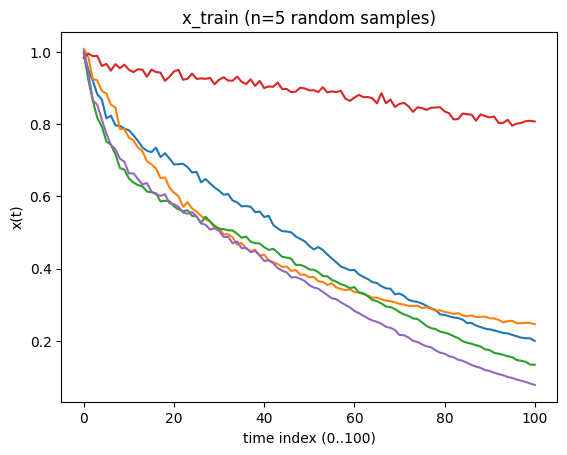

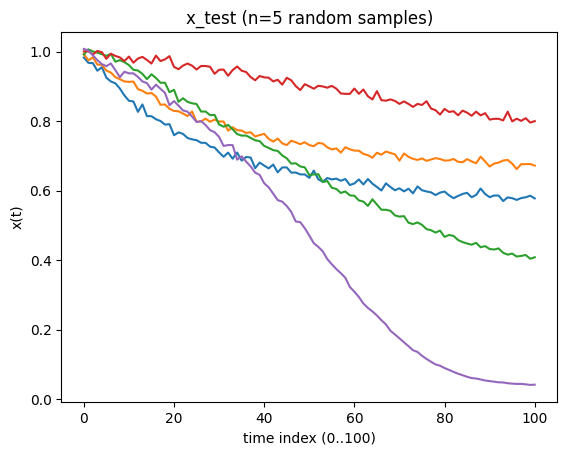

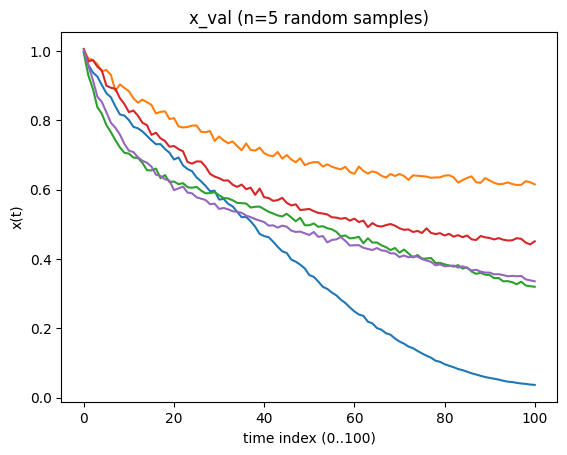

In [7]:
def plot_random_states(x, title, n=5, seed=0):
    rng = np.random.default_rng(seed)
    idxs = rng.integers(0, x.shape[0], size=n)

    plt.figure()
    for i in idxs:
        plt.plot(x[i])
    plt.title(f"{title} (n={n} random samples)")
    plt.xlabel("time index (0..100)")
    plt.ylabel("x(t)")
    plt.show()

plot_random_states(x_train, "x_train", n=5, seed=1)
plot_random_states(x_test,  "x_test",  n=5, seed=2)
plot_random_states(x_val,   "x_val",   n=5, seed=3)